In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy

sys.path.append("/end/home/rh2310/morpho_repo")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-07-07 12:19:07.088917: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1892] Ignoring visible gpu device (device: 0, name: Quadro K2000, pci bus id: 0000:05:00.0, compute capability: 3.0) with Cuda compute capability 3.0. The minimum required Cuda capability is 3.5.


# Load data

In [2]:
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8)}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = dataset['obs_input']
obs_Y = dataset['obs_output']
pde_X = dataset['pde']


In [3]:
data_path = os.path.abspath("turing_model_2.npy")
with open(data_path, 'rb') as f:
    data2 = np.load(f)
    
data_path = os.path.abspath("turing_t_model_2.npy")
with open(data_path, 'rb') as f:
    t_star2 = np.load(f) 
    
T2 = t_star2.shape[0]    
    
L2 = 50
x_size2 = data2.shape[1]
y_size2 = data2.shape[2]
N2 = x_size2*y_size2

model_params2 = {'training_data_size': T2*N2,#T*32,
                'pde_data_size': (T2*N2)//(32),
                'boundary_data_size':((x_size2 + y_size2)*T2)//(8)}

dataset2 = create_dataset(data2, t_star2, N2, T2, L2, **model_params2)
lb2 = dataset['lb']
ub2 = dataset['ub']
obs_X2 = dataset2['obs_input']
obs_Y2 = dataset2['obs_output']
pde_X2 = dataset2['pde']

# Test 

In [4]:
class Non_zero_params(Loss):
    def __init__(self,
                 loss_obj:Loss,
                 print_precision=".5f"):
        super().__init__(name=f"Non-zero params for {loss_obj.name}", print_precision=print_precision)
        self.loss_obj = loss_obj
        #self._trainables_ = loss_obj.trainables()
    
    @tf.function
    def loss(self, pinn, x):
        # Lennard-Jones potential
        params = tf.stack(self.loss_obj.trainables())
        epsilon = params.shape[0]
        twelve = 12*tf.ones_like(params, dtype=pinn.dtype)
        six = 6*tf.ones_like(params, dtype=pinn.dtype)
        return tf.reduce_sum((4e-6/epsilon)*(tf.pow(1e-6/(params+1e-10), twelve) - tf.pow(1e-6/(params+1e-10), six)))        
        
        
    

In [5]:
layers = [3, 64, 64, 64, 64, 2]

pinn = tu.NN(layers, lb, ub, dtype=tf.float64)
pde_loss = ASDM(dtype=tf.float64)
non_zero_loss = Non_zero_params(pde_loss)

In [6]:
model = tu.TINN(pinn, 
                pde_loss, 
                extra_loss = [non_zero_loss], 
                alpha = 0.5, 
                print_precision=".8f")

In [7]:
results = model.train(epochs = 2,
                      batch_size = 512,
                      X = obs_X,
                      Y = obs_Y,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 8.30051613
total loss: 36598.10575834, total regularisd loss: 36598.10575834
obs u loss: 582.82913790, obs v loss: 16416.63328910
pde u loss: 980.02169720, pde v loss: 18618.62163414
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
D_a: 9.74830 D_s: 11.35927 sigma_a: 10.02609 sigma_s: 9.20031 
mu_a: 9.85200 rho_a: 10.51801 rho_s: 11.03346 kappa_a: 8.92998 

extra loss Non-zero params for Loss_ASDM: -0.00000000
Time taken: 53.31s

Start of epoch 1
Training observations acc over epoch: 6.33473778
total loss: 20315.92229593, total regularisd loss: 20315.92229593
obs u loss: 643.51157147, obs v loss: 12330.03950095
pde u loss: 2.33412395, pde v loss: 7340.03709957
lambda obs u: 0.54376012, lambda obs v: 1.96916656
lambda pde u: 0.50000139, lambda pde v: 0.98707193
D_a: 9.48982 D_s: 12.16735 sigma_a: 10.07316 sigma_s: 8.41676 
mu_a: 9.69003 rho_a: 10.94556 rho_s: 11.85081 kappa_a: 8.

In [11]:
results = model.train(epochs = 500,
                      batch_size = 512,
                      X = obs_X,
                      Y = obs_Y,
                      print_interval=1,
                      stop_threshold = 1e-5,
                      shuffle = True,
                      sample_losses = True,              
                      sample_regularisations = True,
                      sample_gradients = True)


Start of epoch 0
Training observations acc over epoch: 3.71528149
total loss: 25352.01068011, total regularisd loss: 25352.01068011
obs u loss: 579.76889571, obs v loss: 13613.77178540
pde u loss: 471.44719073, pde v loss: 10687.02280826
lambda obs u: 1.00000000, lambda obs v: 1.00000000
lambda pde u: 1.00000000, lambda pde v: 1.00000000
D_a:0: 9.71731, D_s:0: 12.36267, sigma_a:0: 10.02123, sigma_s:0: 8.43384, mu_a:0: 9.79264, rho_a:0: 10.34118, rho_s:0: 11.85975, kappa_a:0: 8.04046
extra loss: -0.00000000
Time taken: 86.64s

Start of epoch 1
Training observations acc over epoch: 4.10286665
total loss: 11704.80731901, total regularisd loss: 11704.80731901
obs u loss: 587.54160297, obs v loss: 7815.12431373
pde u loss: 0.85487465, pde v loss: 3301.28652765
lambda obs u: 0.55802689, lambda obs v: 2.16515375
lambda pde u: 0.50000044, lambda pde v: 0.77681892
D_a:0: 9.53462, D_s:0: 13.30064, sigma_a:0: 10.06413, sigma_s:0: 7.61515, mu_a:0: 9.69538, rho_a:0: 10.49950, rho_s:0: 12.66910, ka

Training observations acc over epoch: 0.12332802
total loss: 3159.54073240, total regularisd loss: 795.24611331
obs u loss: 202.18911986, obs v loss: 50.38656176
pde u loss: 252.78854739, pde v loss: 110.58108629
lambda obs u: 3.61190369, lambda obs v: 0.09995834
lambda pde u: 0.18299844, lambda pde v: 0.10513953
D_a:0: 7.18809, D_s:0: 12.75139, sigma_a:0: 7.38985, sigma_s:0: 4.24527, mu_a:0: 10.23133, rho_a:0: 9.74464, rho_s:0: 14.69670, kappa_a:0: 3.17640
extra loss: -0.00000000
Time taken: 43.66s

Start of epoch 17
Training observations acc over epoch: 0.12019077
total loss: 3563.93568061, total regularisd loss: 775.68672294
obs u loss: 193.72863832, obs v loss: 52.42208778
pde u loss: 307.61321866, pde v loss: 137.19649498
lambda obs u: 3.51067611, lambda obs v: 0.10303197
lambda pde u: 0.24365534, lambda pde v: 0.14263658
D_a:0: 6.08241, D_s:0: 11.75627, sigma_a:0: 7.12027, sigma_s:0: 4.15685, mu_a:0: 10.04199, rho_a:0: 9.96416, rho_s:0: 14.20637, kappa_a:0: 3.09671
extra loss: -0

Training observations acc over epoch: 0.03942436
total loss: 307.90124007, total regularisd loss: 151.81950126
obs u loss: 24.89673607, obs v loss: 55.84436793
pde u loss: 78.78326232, pde v loss: 28.94866743
lambda obs u: 1.26048779, lambda obs v: 1.28253641
lambda pde u: 0.62348482, lambda pde v: 0.83349099
D_a:0: 0.03177, D_s:0: 0.04401, sigma_a:0: 0.03177, sigma_s:0: 0.36797, mu_a:0: 4.64677, rho_a:0: 14.90568, rho_s:0: 1.20450, kappa_a:0: 2.64421
extra loss: -0.00000000
Time taken: 43.71s

Start of epoch 33
Training observations acc over epoch: 0.03835144
total loss: 167.76929704, total regularisd loss: 145.13170866
obs u loss: 30.13717103, obs v loss: 48.40661978
pde u loss: 58.39967468, pde v loss: 10.37756868
lambda obs u: 1.01483975, lambda obs v: 1.71581581
lambda pde u: 0.69590958, lambda pde v: 0.57343487
D_a:0: 0.03177, D_s:0: 0.02956, sigma_a:0: 0.03177, sigma_s:0: 0.20187, mu_a:0: 4.75255, rho_a:0: 14.36789, rho_s:0: 0.63238, kappa_a:0: 2.50569
extra loss: -0.00000000
Ti

Training observations acc over epoch: 0.00880038
total loss: 79.99869500, total regularisd loss: 39.99955794
obs u loss: 8.93940973, obs v loss: 9.08376426
pde u loss: 16.54310908, pde v loss: 0.11000157
lambda obs u: 1.69769533, lambda obs v: 1.76530923
lambda pde u: 0.53420747, lambda pde v: 0.00278797
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00544, mu_a:0: 6.10879, rho_a:0: 10.37966, rho_s:0: 0.00860, kappa_a:0: 0.91203
extra loss: -0.00000000
Time taken: 44.33s

Start of epoch 49
Training observations acc over epoch: 0.00864510
total loss: 79.45113278, total regularisd loss: 39.12584075
obs u loss: 8.84040541, obs v loss: 8.86475534
pde u loss: 15.85186356, pde v loss: 0.11026019
lambda obs u: 1.67072844, lambda obs v: 1.78903832
lambda pde u: 0.53744622, lambda pde v: 0.00278702
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00524, mu_a:0: 6.08967, rho_a:0: 10.26899, rho_s:0: 0.00861, kappa_a:0: 0.90008
extra loss: -0.00000000
Time taken: 

Training observations acc over epoch: 0.00741376
total loss: 105.29513682, total regularisd loss: 32.72537575
obs u loss: 8.06502481, obs v loss: 7.11836055
pde u loss: 12.19143053, pde v loss: 0.15259672
lambda obs u: 1.57566584, lambda obs v: 1.89636773
lambda pde u: 0.52594566, lambda pde v: 0.00202077
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00701, mu_a:0: 5.50953, rho_a:0: 8.91080, rho_s:0: 0.01114, kappa_a:0: 0.83032
extra loss: -0.00000000
Time taken: 43.48s

Start of epoch 65
Training observations acc over epoch: 0.00726092
total loss: 120.45698766, total regularisd loss: 32.26606275
obs u loss: 7.90418038, obs v loss: 6.96619460
pde u loss: 12.55051741, pde v loss: 0.17763481
lambda obs u: 1.57086336, lambda obs v: 1.87916649
lambda pde u: 0.54778621, lambda pde v: 0.00218394
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00644, mu_a:0: 5.46129, rho_a:0: 8.82325, rho_s:0: 0.00906, kappa_a:0: 0.82869
extra loss: -0.00000000
Time taken: 

Training observations acc over epoch: 0.00662405
total loss: 74.12060693, total regularisd loss: 28.93902146
obs u loss: 7.23976659, obs v loss: 6.32628700
pde u loss: 9.96543297, pde v loss: 0.14359749
lambda obs u: 1.51405879, lambda obs v: 1.88984430
lambda pde u: 0.59350696, lambda pde v: 0.00258996
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00613, mu_a:0: 4.62048, rho_a:0: 7.35909, rho_s:0: 0.00871, kappa_a:0: 0.80820
extra loss: -0.00000000
Time taken: 44.21s

Start of epoch 81
Training observations acc over epoch: 0.00632545
total loss: 141.72918437, total regularisd loss: 28.04923842
obs u loss: 6.77910553, obs v loss: 6.17542579
pde u loss: 10.30130906, pde v loss: 0.30206016
lambda obs u: 1.48452653, lambda obs v: 1.86454679
lambda pde u: 0.64761043, lambda pde v: 0.00331625
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00831, mu_a:0: 4.55666, rho_a:0: 7.24785, rho_s:0: 0.01152, kappa_a:0: 0.80478
extra loss: -0.00000000
Time taken: 43

Training observations acc over epoch: 0.00522387
total loss: 43.75117187, total regularisd loss: 23.27759636
obs u loss: 5.52452519, obs v loss: 5.17396959
pde u loss: 7.84252967, pde v loss: 0.13990553
lambda obs u: 1.31874672, lambda obs v: 1.82090755
lambda pde u: 0.85520777, lambda pde v: 0.00513796
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00658, mu_a:0: 3.23828, rho_a:0: 5.05831, rho_s:0: 0.00941, kappa_a:0: 0.78261
extra loss: -0.00000000
Time taken: 43.93s

Start of epoch 98
Training observations acc over epoch: 0.00522425
total loss: 42.09197684, total regularisd loss: 22.83980768
obs u loss: 5.60644973, obs v loss: 5.09281979
pde u loss: 7.21703471, pde v loss: 0.13669463
lambda obs u: 1.34391553, lambda obs v: 1.80318309
lambda pde u: 0.84770448, lambda pde v: 0.00519690
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00611, mu_a:0: 3.13192, rho_a:0: 4.87571, rho_s:0: 0.00821, kappa_a:0: 0.77733
extra loss: -0.00000000
Time taken: 43.8

Training observations acc over epoch: 0.00083521
total loss: 3.19446024, total regularisd loss: 2.29912258
obs u loss: 1.18636307, obs v loss: 0.52414297
pde u loss: 0.26762830, pde v loss: 0.01802621
lambda obs u: 1.47454166, lambda obs v: 1.14874411
lambda pde u: 1.36171220, lambda pde v: 0.01500204
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00361, mu_a:0: 0.33532, rho_a:0: 0.34206, rho_s:0: 0.00421, kappa_a:0: 0.36266
extra loss: -0.00000000
Time taken: 43.76s

Start of epoch 115
Training observations acc over epoch: 0.00076546
total loss: 2.09208097, total regularisd loss: 2.31883372
obs u loss: 1.12825529, obs v loss: 0.43940016
pde u loss: 0.11031818, pde v loss: 0.01295284
lambda obs u: 1.96145559, lambda obs v: 1.08233348
lambda pde u: 0.93761305, lambda pde v: 0.01859788
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00328, mu_a:0: 0.26050, rho_a:0: 0.24244, rho_s:0: 0.00346, kappa_a:0: 0.30227
extra loss: -0.00000000
Time taken: 43.61s


Training observations acc over epoch: 0.00047538
total loss: 1.13783919, total regularisd loss: 2.13590679
obs u loss: 0.69509834, obs v loss: 0.27847393
pde u loss: 0.06596270, pde v loss: 0.00825020
lambda obs u: 2.68428254, lambda obs v: 0.84180148
lambda pde u: 0.45300008, lambda pde v: 0.02091590
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00336, mu_a:0: 0.20484, rho_a:0: 0.17020, rho_s:0: 0.00294, kappa_a:0: 0.23098
extra loss: -0.00000000
Time taken: 43.92s

Start of epoch 132
Training observations acc over epoch: 0.00048314
total loss: 1.11803657, total regularisd loss: 2.17170654
obs u loss: 0.71035883, obs v loss: 0.27911264
pde u loss: 0.06574060, pde v loss: 0.00787926
lambda obs u: 2.67925501, lambda obs v: 0.83449802
lambda pde u: 0.46435369, lambda pde v: 0.02189328
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00338, mu_a:0: 0.20516, rho_a:0: 0.16960, rho_s:0: 0.00329, kappa_a:0: 0.22985
extra loss: -0.00000000
Time taken: 44.42s


Training observations acc over epoch: 0.00040502
total loss: 0.89643657, total regularisd loss: 1.79864862
obs u loss: 0.60367048, obs v loss: 0.22581913
pde u loss: 0.06235016, pde v loss: 0.00663482
lambda obs u: 2.63822791, lambda obs v: 0.75978839
lambda pde u: 0.57659791, lambda pde v: 0.02538579
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00309, mu_a:0: 0.20057, rho_a:0: 0.16508, rho_s:0: 0.00305, kappa_a:0: 0.22483
extra loss: -0.00000000
Time taken: 43.88s

Start of epoch 149
Training observations acc over epoch: 0.00040531
total loss: 0.88265157, total regularisd loss: 1.80130733
obs u loss: 0.60400436, obs v loss: 0.22607124
pde u loss: 0.06222688, pde v loss: 0.00630183
lambda obs u: 2.63690433, lambda obs v: 0.75392195
lambda pde u: 0.58293489, lambda pde v: 0.02623884
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00290, mu_a:0: 0.20098, rho_a:0: 0.16432, rho_s:0: 0.00299, kappa_a:0: 0.22385
extra loss: -0.00000000
Time taken: 43.67s


Training observations acc over epoch: 0.00035603
total loss: 0.75975243, total regularisd loss: 1.54846719
obs u loss: 0.52833553, obs v loss: 0.20080712
pde u loss: 0.06031395, pde v loss: 0.00539946
lambda obs u: 2.57294708, lambda obs v: 0.73995008
lambda pde u: 0.65895446, lambda pde v: 0.02814838
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00294, mu_a:0: 0.19900, rho_a:0: 0.16266, rho_s:0: 0.00287, kappa_a:0: 0.22042
extra loss: -0.00000000
Time taken: 44.23s

Start of epoch 166
Training observations acc over epoch: 0.00036949
total loss: 0.77557419, total regularisd loss: 1.61181262
obs u loss: 0.55207899, obs v loss: 0.20464465
pde u loss: 0.06034249, pde v loss: 0.00542884
lambda obs u: 2.56093503, lambda obs v: 0.73417483
lambda pde u: 0.67631331, lambda pde v: 0.02857683
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00316, mu_a:0: 0.19909, rho_a:0: 0.16241, rho_s:0: 0.00314, kappa_a:0: 0.22157
extra loss: -0.00000000
Time taken: 44.13s


Training observations acc over epoch: 0.00033368
total loss: 0.70577877, total regularisd loss: 1.42037499
obs u loss: 0.49485828, obs v loss: 0.18851258
pde u loss: 0.05921788, pde v loss: 0.00486222
lambda obs u: 2.49590481, lambda obs v: 0.73062668
lambda pde u: 0.74536093, lambda pde v: 0.02810757
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00307, mu_a:0: 0.19885, rho_a:0: 0.16160, rho_s:0: 0.00287, kappa_a:0: 0.22012
extra loss: -0.00000000
Time taken: 43.59s

Start of epoch 183
Training observations acc over epoch: 0.00032901
total loss: 0.70118589, total regularisd loss: 1.39671555
obs u loss: 0.48728521, obs v loss: 0.18653735
pde u loss: 0.05913046, pde v loss: 0.00481509
lambda obs u: 2.48925309, lambda obs v: 0.73635638
lambda pde u: 0.74555076, lambda pde v: 0.02883977
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00293, mu_a:0: 0.19827, rho_a:0: 0.16144, rho_s:0: 0.00294, kappa_a:0: 0.22024
extra loss: -0.00000000
Time taken: 43.60s


Training observations acc over epoch: 0.00031154
total loss: 0.65980314, total regularisd loss: 1.31608101
obs u loss: 0.46347159, obs v loss: 0.17455326
pde u loss: 0.05855646, pde v loss: 0.00454117
lambda obs u: 2.45270576, lambda obs v: 0.71171247
lambda pde u: 0.80587817, lambda pde v: 0.02970361
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00315, mu_a:0: 0.19845, rho_a:0: 0.16087, rho_s:0: 0.00290, kappa_a:0: 0.21956
extra loss: -0.00000000
Time taken: 43.60s

Start of epoch 200
Training observations acc over epoch: 0.00030758
total loss: 0.65605422, total regularisd loss: 1.28941356
obs u loss: 0.45594773, obs v loss: 0.17398118
pde u loss: 0.05850547, pde v loss: 0.00454779
lambda obs u: 2.43309026, lambda obs v: 0.71271246
lambda pde u: 0.82381419, lambda pde v: 0.03038309
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00295, mu_a:0: 0.19808, rho_a:0: 0.16073, rho_s:0: 0.00306, kappa_a:0: 0.21932
extra loss: -0.00000000
Time taken: 43.45s


Training observations acc over epoch: 0.00028728
total loss: 0.61686410, total regularisd loss: 1.17941653
obs u loss: 0.42374829, obs v loss: 0.16460266
pde u loss: 0.05791945, pde v loss: 0.00445145
lambda obs u: 2.39288311, lambda obs v: 0.70702644
lambda pde u: 0.86812228, lambda pde v: 0.03196817
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00312, mu_a:0: 0.19763, rho_a:0: 0.16028, rho_s:0: 0.00281, kappa_a:0: 0.21813
extra loss: -0.00000000
Time taken: 44.50s

Start of epoch 217
Training observations acc over epoch: 0.00030070
total loss: 0.63094534, total regularisd loss: 1.24105462
obs u loss: 0.44790870, obs v loss: 0.16792910
pde u loss: 0.05804332, pde v loss: 0.00445592
lambda obs u: 2.38841794, lambda obs v: 0.69871669
lambda pde u: 0.88137484, lambda pde v: 0.03149053
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00274, mu_a:0: 0.19750, rho_a:0: 0.16024, rho_s:0: 0.00290, kappa_a:0: 0.21861
extra loss: -0.00000000
Time taken: 44.22s


Training observations acc over epoch: 0.00027981
total loss: 0.60167014, total regularisd loss: 1.12925577
obs u loss: 0.41377303, obs v loss: 0.15928652
pde u loss: 0.05739965, pde v loss: 0.00445432
lambda obs u: 2.32272381, lambda obs v: 0.69524476
lambda pde u: 0.94845281, lambda pde v: 0.03357861
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00306, mu_a:0: 0.19676, rho_a:0: 0.16028, rho_s:0: 0.00275, kappa_a:0: 0.21762
extra loss: -0.00000000
Time taken: 43.96s

Start of epoch 234
Training observations acc over epoch: 0.00027105
total loss: 0.59057352, total regularisd loss: 1.08999186
obs u loss: 0.39908163, obs v loss: 0.15602007
pde u loss: 0.05736964, pde v loss: 0.00449481
lambda obs u: 2.30990904, lambda obs v: 0.70427934
lambda pde u: 0.95260598, lambda pde v: 0.03320564
D_a:0: 0.03177, D_s:0: 0.03177, sigma_a:0: 0.03177, sigma_s:0: 0.00289, mu_a:0: 0.19715, rho_a:0: 0.15981, rho_s:0: 0.00275, kappa_a:0: 0.21818
extra loss: -0.00000000
Time taken: 43.53s


Training observations acc over epoch: 0.00026051
total loss: 0.56851067, total regularisd loss: 1.03478214
obs u loss: 0.38392807, obs v loss: 0.14959101
pde u loss: 0.05603392, pde v loss: 0.00454294
lambda obs u: 2.26736749, lambda obs v: 0.69687393
lambda pde u: 0.99920518, lambda pde v: 0.03655340
D_a:0: 0.03113, D_s:0: 0.03177, sigma_a:0: 0.03176, sigma_s:0: 0.00289, mu_a:0: 0.19629, rho_a:0: 0.15854, rho_s:0: 0.00277, kappa_a:0: 0.21742
extra loss: -0.00000000
Time taken: 44.04s

Start of epoch 251
Training observations acc over epoch: 0.00026581
total loss: 0.57137464, total regularisd loss: 1.05106207
obs u loss: 0.39228351, obs v loss: 0.15208627
pde u loss: 0.05550391, pde v loss: 0.00455357
lambda obs u: 2.30577225, lambda obs v: 0.68208806
lambda pde u: 0.97466361, lambda pde v: 0.03747609
D_a:0: 0.03071, D_s:0: 0.03177, sigma_a:0: 0.03175, sigma_s:0: 0.00343, mu_a:0: 0.19481, rho_a:0: 0.15760, rho_s:0: 0.00271, kappa_a:0: 0.21646
extra loss: -0.00000000
Time taken: 43.84s


Training observations acc over epoch: 0.00025476
total loss: 0.44038924, total regularisd loss: 1.20441351
obs u loss: 0.37779481, obs v loss: 0.14394986
pde u loss: 0.00989034, pde v loss: 0.00438051
lambda obs u: 2.91682185, lambda obs v: 0.85031538
lambda pde u: 0.18554676, lambda pde v: 0.04731600
D_a:0: 0.00199, D_s:0: 0.03176, sigma_a:0: 0.01593, sigma_s:0: 0.00308, mu_a:0: 0.07399, rho_a:0: 0.05533, rho_s:0: 0.00266, kappa_a:0: 0.20176
extra loss: -0.00000000
Time taken: 43.95s

Start of epoch 268
Training observations acc over epoch: 0.00024946
total loss: 0.42195897, total regularisd loss: 1.19597582
obs u loss: 0.36784270, obs v loss: 0.14306108
pde u loss: 0.00640698, pde v loss: 0.00440385
lambda obs u: 2.96161219, lambda obs v: 0.86481299
lambda pde u: 0.12510459, lambda pde v: 0.04847024
D_a:0: 0.00167, D_s:0: 0.03176, sigma_a:0: 0.01253, sigma_s:0: 0.00303, mu_a:0: 0.05884, rho_a:0: 0.04402, rho_s:0: 0.00275, kappa_a:0: 0.20302
extra loss: -0.00000000
Time taken: 44.03s


Training observations acc over epoch: 0.00023551
total loss: 0.68138046, total regularisd loss: 1.19071505
obs u loss: 0.34839435, obs v loss: 0.13393482
pde u loss: 0.00001113, pde v loss: 0.00192126
lambda obs u: 3.07633277, lambda obs v: 0.89965129
lambda pde u: 0.00001887, lambda pde v: 0.02399707
D_a:0: 0.00007, D_s:0: 0.01928, sigma_a:0: 0.00034, sigma_s:0: 0.00204, mu_a:0: 0.00213, rho_a:0: 0.00196, rho_s:0: 0.00200, kappa_a:0: 0.32885
extra loss: -0.00000000
Time taken: 43.75s

Start of epoch 285
Training observations acc over epoch: 0.00023959
total loss: 0.77933540, total regularisd loss: 1.21171717
obs u loss: 0.35386230, obs v loss: 0.13681588
pde u loss: 0.00000860, pde v loss: 0.00135040
lambda obs u: 3.08719385, lambda obs v: 0.89552935
lambda pde u: 0.00001211, lambda pde v: 0.01726469
D_a:0: 0.00008, D_s:0: 0.01569, sigma_a:0: 0.00028, sigma_s:0: 0.00145, mu_a:0: 0.00187, rho_a:0: 0.00174, rho_s:0: 0.00170, kappa_a:0: 0.32947
extra loss: -0.00000000
Time taken: 43.89s


Training observations acc over epoch: 0.00023006
total loss: 2.16390499, total regularisd loss: 1.17154177
obs u loss: 0.34030701, obs v loss: 0.13086445
pde u loss: 0.00000296, pde v loss: 0.00000241
lambda obs u: 3.11294314, lambda obs v: 0.88705148
lambda pde u: 0.00000198, lambda pde v: 0.00000341
D_a:0: 0.00007, D_s:0: 0.00066, sigma_a:0: 0.00009, sigma_s:0: 0.00007, mu_a:0: 0.00083, rho_a:0: 0.00080, rho_s:0: 0.00007, kappa_a:0: 0.32980
extra loss: -0.00000000
Time taken: 43.66s

Start of epoch 302
Training observations acc over epoch: 0.00022444
total loss: 2.28960744, total regularisd loss: 1.14374130
obs u loss: 0.33065534, obs v loss: 0.12900043
pde u loss: 0.00000289, pde v loss: 0.00000196
lambda obs u: 3.11749288, lambda obs v: 0.88250289
lambda pde u: 0.00000195, lambda pde v: 0.00000229
D_a:0: 0.00006, D_s:0: 0.00059, sigma_a:0: 0.00009, sigma_s:0: 0.00006, mu_a:0: 0.00080, rho_a:0: 0.00078, rho_s:0: 0.00007, kappa_a:0: 0.32980
extra loss: -0.00000000
Time taken: 44.28s


Training observations acc over epoch: 0.00024923
total loss: 1.67167190, total regularisd loss: 1.11303305
obs u loss: 0.36051100, obs v loss: 0.14991093
pde u loss: 0.32756211, pde v loss: 0.14871098
lambda obs u: 0.59731648, lambda obs v: 0.19670735
lambda pde u: 2.22044217, lambda pde v: 0.98553400
D_a:0: 0.03177, D_s:0: 0.17925, sigma_a:0: 0.03177, sigma_s:0: 0.02987, mu_a:0: 0.03177, rho_a:0: 0.00704, rho_s:0: 0.01827, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.23s

Start of epoch 318
Training observations acc over epoch: 0.00024655
total loss: 1.63767866, total regularisd loss: 1.10499848
obs u loss: 0.35726062, obs v loss: 0.14767856
pde u loss: 0.32643007, pde v loss: 0.13975396
lambda obs u: 0.59790398, lambda obs v: 0.19869536
lambda pde u: 2.26334493, lambda pde v: 0.94005574
D_a:0: 0.03177, D_s:0: 0.17255, sigma_a:0: 0.03177, sigma_s:0: 0.02873, mu_a:0: 0.03177, rho_a:0: 0.00725, rho_s:0: 0.01755, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.25s


Training observations acc over epoch: 0.00023339
total loss: 1.38516609, total regularisd loss: 1.23707567
obs u loss: 0.34905015, obs v loss: 0.12892953
pde u loss: 0.31158883, pde v loss: 0.00019543
lambda obs u: 0.81696362, lambda obs v: 0.21715400
lambda pde u: 2.96547215, lambda pde v: 0.00041023
D_a:0: 0.03177, D_s:0: 0.00443, sigma_a:0: 0.03177, sigma_s:0: 0.00090, mu_a:0: 0.03177, rho_a:0: 0.00741, rho_s:0: 0.00053, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.31s

Start of epoch 335
Training observations acc over epoch: 0.00023584
total loss: 1.50329086, total regularisd loss: 1.23768782
obs u loss: 0.35272348, obs v loss: 0.13028272
pde u loss: 0.31065343, pde v loss: 0.00015048
lambda obs u: 0.79940252, lambda obs v: 0.21478014
lambda pde u: 2.98559227, lambda pde v: 0.00022508
D_a:0: 0.03177, D_s:0: 0.00380, sigma_a:0: 0.03177, sigma_s:0: 0.00079, mu_a:0: 0.03177, rho_a:0: 0.00718, rho_s:0: 0.00047, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.21s


Training observations acc over epoch: 0.00023048
total loss: 7.41363855, total regularisd loss: 1.18788048
obs u loss: 0.34181775, obs v loss: 0.13019654
pde u loss: 0.29732495, pde v loss: 0.00000372
lambda obs u: 0.81003035, lambda obs v: 0.22403945
lambda pde u: 2.96592963, lambda pde v: 0.00000057
D_a:0: 0.03177, D_s:0: 0.00092, sigma_a:0: 0.03177, sigma_s:0: 0.00007, mu_a:0: 0.03177, rho_a:0: 0.00748, rho_s:0: 0.00005, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 43.95s

Start of epoch 352
Training observations acc over epoch: 0.00023032
total loss: 7.07917696, total regularisd loss: 1.18585022
obs u loss: 0.34227302, obs v loss: 0.12942200
pde u loss: 0.29656909, pde v loss: 0.00000340
lambda obs u: 0.81337975, lambda obs v: 0.22511280
lambda pde u: 2.96150691, lambda pde v: 0.00000054
D_a:0: 0.03177, D_s:0: 0.00088, sigma_a:0: 0.03177, sigma_s:0: 0.00006, mu_a:0: 0.03177, rho_a:0: 0.00765, rho_s:0: 0.00005, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.02s


Training observations acc over epoch: 0.00027591
total loss: 1.80187997, total regularisd loss: 1.19019001
obs u loss: 0.36592382, obs v loss: 0.19913706
pde u loss: 0.29539253, pde v loss: 0.29406470
lambda obs u: 0.52812565, lambda obs v: 0.26741951
lambda pde u: 1.61690686, lambda pde v: 1.58754799
D_a:0: 0.03177, D_s:0: 0.33882, sigma_a:0: 0.03177, sigma_s:0: 0.04282, mu_a:0: 0.03177, rho_a:0: 0.00753, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.30s

Start of epoch 368
Training observations acc over epoch: 0.00027395
total loss: 1.79821786, total regularisd loss: 1.18619184
obs u loss: 0.36119593, obs v loss: 0.19985572
pde u loss: 0.29503692, pde v loss: 0.29286829
lambda obs u: 0.51625997, lambda obs v: 0.26550939
lambda pde u: 1.62572020, lambda pde v: 1.59251044
D_a:0: 0.03177, D_s:0: 0.34113, sigma_a:0: 0.03177, sigma_s:0: 0.04326, mu_a:0: 0.03177, rho_a:0: 0.00733, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.16s


Training observations acc over epoch: 0.00027325
total loss: 1.81372052, total regularisd loss: 1.15611799
obs u loss: 0.36392376, obs v loss: 0.19569681
pde u loss: 0.28862710, pde v loss: 0.28086198
lambda obs u: 0.51312631, lambda obs v: 0.26455268
lambda pde u: 1.64466312, lambda pde v: 1.57765789
D_a:0: 0.03177, D_s:0: 0.34445, sigma_a:0: 0.03177, sigma_s:0: 0.04401, mu_a:0: 0.03177, rho_a:0: 0.00743, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.17s

Start of epoch 385
Training observations acc over epoch: 0.00026268
total loss: 1.75399989, total regularisd loss: 1.14510632
obs u loss: 0.34552581, obs v loss: 0.19245090
pde u loss: 0.28836687, pde v loss: 0.28056031
lambda obs u: 0.52303278, lambda obs v: 0.26755344
lambda pde u: 1.63720319, lambda pde v: 1.57221059
D_a:0: 0.03177, D_s:0: 0.34631, sigma_a:0: 0.03177, sigma_s:0: 0.04324, mu_a:0: 0.03177, rho_a:0: 0.00694, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 43.84s


Training observations acc over epoch: 0.00026129
total loss: 1.73942542, total regularisd loss: 1.12500873
obs u loss: 0.34636374, obs v loss: 0.18875420
pde u loss: 0.28315691, pde v loss: 0.27396998
lambda obs u: 0.50816064, lambda obs v: 0.26228904
lambda pde u: 1.65157453, lambda pde v: 1.57797579
D_a:0: 0.03177, D_s:0: 0.34906, sigma_a:0: 0.03177, sigma_s:0: 0.04355, mu_a:0: 0.03177, rho_a:0: 0.00704, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.02s

Start of epoch 402
Training observations acc over epoch: 0.00026786
total loss: 1.77558783, total regularisd loss: 1.13085234
obs u loss: 0.35808146, obs v loss: 0.19049225
pde u loss: 0.28297919, pde v loss: 0.27349227
lambda obs u: 0.50697167, lambda obs v: 0.26203519
lambda pde u: 1.65286800, lambda pde v: 1.57812514
D_a:0: 0.03177, D_s:0: 0.34850, sigma_a:0: 0.03177, sigma_s:0: 0.04290, mu_a:0: 0.03177, rho_a:0: 0.00740, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 43.76s


Training observations acc over epoch: 0.00026163
total loss: 1.76006800, total regularisd loss: 1.11011797
obs u loss: 0.34884071, obs v loss: 0.18698536
pde u loss: 0.27881945, pde v loss: 0.26856984
lambda obs u: 0.50291044, lambda obs v: 0.26263068
lambda pde u: 1.65712529, lambda pde v: 1.57733359
D_a:0: 0.03177, D_s:0: 0.34916, sigma_a:0: 0.03177, sigma_s:0: 0.04245, mu_a:0: 0.03177, rho_a:0: 0.00727, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.03s

Start of epoch 419
Training observations acc over epoch: 0.00025704
total loss: 1.72455541, total regularisd loss: 1.10499474
obs u loss: 0.33978275, obs v loss: 0.18662756
pde u loss: 0.27854267, pde v loss: 0.26850390
lambda obs u: 0.49819620, lambda obs v: 0.25977601
lambda pde u: 1.66152572, lambda pde v: 1.58050207
D_a:0: 0.03177, D_s:0: 0.35315, sigma_a:0: 0.03177, sigma_s:0: 0.04329, mu_a:0: 0.03177, rho_a:0: 0.00698, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.12s


Training observations acc over epoch: 0.00026119
total loss: 1.72449808, total regularisd loss: 1.09935606
obs u loss: 0.35046703, obs v loss: 0.18445191
pde u loss: 0.27506576, pde v loss: 0.26528343
lambda obs u: 0.49725701, lambda obs v: 0.25750977
lambda pde u: 1.66304918, lambda pde v: 1.58218405
D_a:0: 0.03177, D_s:0: 0.35470, sigma_a:0: 0.03177, sigma_s:0: 0.04332, mu_a:0: 0.03177, rho_a:0: 0.00734, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.44s

Start of epoch 436
Training observations acc over epoch: 0.00025390
total loss: 1.72155930, total regularisd loss: 1.08989625
obs u loss: 0.33653563, obs v loss: 0.18345797
pde u loss: 0.27471959, pde v loss: 0.26446806
lambda obs u: 0.50324562, lambda obs v: 0.26214464
lambda pde u: 1.65785515, lambda pde v: 1.57675458
D_a:0: 0.03177, D_s:0: 0.35816, sigma_a:0: 0.03177, sigma_s:0: 0.04300, mu_a:0: 0.03177, rho_a:0: 0.00712, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 43.90s


Training observations acc over epoch: 0.00025027
total loss: 1.68630579, total regularisd loss: 1.07657388
obs u loss: 0.33242052, obs v loss: 0.18012710
pde u loss: 0.27162640, pde v loss: 0.26152805
lambda obs u: 0.48830334, lambda obs v: 0.26081324
lambda pde u: 1.66574251, lambda pde v: 1.58514091
D_a:0: 0.03177, D_s:0: 0.35745, sigma_a:0: 0.03177, sigma_s:0: 0.04340, mu_a:0: 0.03177, rho_a:0: 0.00764, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.54s

Start of epoch 453
Training observations acc over epoch: 0.00025022
total loss: 1.70064041, total regularisd loss: 1.07498608
obs u loss: 0.33130597, obs v loss: 0.18113689
pde u loss: 0.27140210, pde v loss: 0.26109941
lambda obs u: 0.49143029, lambda obs v: 0.25932608
lambda pde u: 1.66554314, lambda pde v: 1.58370049
D_a:0: 0.03177, D_s:0: 0.35721, sigma_a:0: 0.03177, sigma_s:0: 0.04230, mu_a:0: 0.03177, rho_a:0: 0.00778, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.43s


Training observations acc over epoch: 0.00025264
total loss: 1.69779980, total regularisd loss: 1.07030009
obs u loss: 0.33687335, obs v loss: 0.18053252
pde u loss: 0.26915526, pde v loss: 0.25856048
lambda obs u: 0.49447701, lambda obs v: 0.25578107
lambda pde u: 1.66968010, lambda pde v: 1.58006182
D_a:0: 0.03177, D_s:0: 0.35702, sigma_a:0: 0.03177, sigma_s:0: 0.04299, mu_a:0: 0.03177, rho_a:0: 0.00748, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.23s

Start of epoch 470
Training observations acc over epoch: 0.00024971
total loss: 1.69994589, total regularisd loss: 1.06733163
obs u loss: 0.33072243, obs v loss: 0.18068828
pde u loss: 0.26915246, pde v loss: 0.25833283
lambda obs u: 0.49147213, lambda obs v: 0.25772456
lambda pde u: 1.67010716, lambda pde v: 1.58069615
D_a:0: 0.03177, D_s:0: 0.35425, sigma_a:0: 0.03177, sigma_s:0: 0.04283, mu_a:0: 0.03177, rho_a:0: 0.00753, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.05s


Training observations acc over epoch: 0.00024334
total loss: 1.66041530, total regularisd loss: 1.05384919
obs u loss: 0.32144009, obs v loss: 0.17692117
pde u loss: 0.26722203, pde v loss: 0.25602383
lambda obs u: 0.48434573, lambda obs v: 0.25998138
lambda pde u: 1.67238661, lambda pde v: 1.58328628
D_a:0: 0.03177, D_s:0: 0.36006, sigma_a:0: 0.03177, sigma_s:0: 0.04335, mu_a:0: 0.03177, rho_a:0: 0.00796, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.45s

Start of epoch 487
Training observations acc over epoch: 0.00024363
total loss: 1.66692022, total regularisd loss: 1.05349286
obs u loss: 0.32184708, obs v loss: 0.17709833
pde u loss: 0.26704013, pde v loss: 0.25577876
lambda obs u: 0.47687979, lambda obs v: 0.25933405
lambda pde u: 1.67745487, lambda pde v: 1.58633129
D_a:0: 0.03177, D_s:0: 0.35782, sigma_a:0: 0.03177, sigma_s:0: 0.04338, mu_a:0: 0.03177, rho_a:0: 0.00744, rho_s:0: 0.03177, kappa_a:0: 0.03177
extra loss: -0.00000000
Time taken: 44.11s


In [15]:
def LJ(x):
    return 4*((1e-6/x)**12 - (1e-6/x)**6)

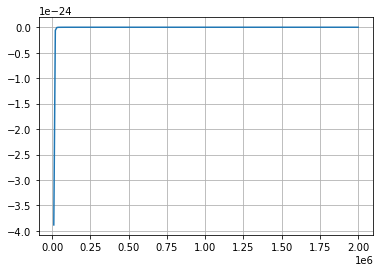

In [16]:
x = np.linspace(0,2, 200)
plt.plot(x/1e-6, LJ(x))
#plt.yscale('log')
plt.grid()
plt.show()